## Mini Project 4, Practical Face Recognition##
###Vaishali Shukla###
###Enrollment Id:16325790###


In [ ]:
#Unzipping dataset
!unzip '/content/drive/MyDrive/clean_data.zip'

Archive:  /content/drive/MyDrive/clean_data.zip
replace process_data/train/s10/7.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#importing all necesssary libraries
import os
import zipfile
import numpy as np
from PIL import Image
import cv2

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from scipy.spatial.distance import cosine

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import Input
from keras import regularizers
from keras.models import Model
from keras.optimizers import SGD

from keras.layers import Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

In [ ]:
# set the paths to the dataset and training/validation directories
data_dir = '/content/process_data'
train_dir = '/content/process_data/train'
valid_dir = '/content/process_data/valid'


###Data  Processing###

In [ ]:
# Define a dictionary to map folder names to integer labels
label_map = {}
for i, folder in enumerate(sorted(os.listdir(data_dir))):
    label_map[folder] = i

# Load the image data and labels
X = []
y = []
for folder in os.listdir(data_dir):
    label = label_map[folder]
    for filename in os.listdir(os.path.join(data_dir, folder)):
        img = cv2.imread(os.path.join(data_dir, folder, filename))
        X.append(img)
        y.append(label)

# Convert the data and labels to numpy arrays
X = np.array(X)
y = np.array(y)


# initialize the lists for the training and validation data
x_train, y_train, x_valid, y_valid = [], [], [], []

# loop over the directories in the training set and load the images
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        x_train.append(img)
        identity_number = class_dir[1:]
        y_train.append(int(identity_number))

# loop over the directories in the validation set and load the images
for class_dir in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_dir)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        x_valid.append(img)
        identity_number = class_dir[1:]
        y_valid.append(int(identity_number))

# convert the lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

# print the shapes of the training and validation data
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_valid shape:', x_valid.shape)
print('y_valid shape:', y_valid.shape)


x_train shape: (280, 224, 224, 3)
y_train shape: (280,)
x_valid shape: (120, 224, 224, 3)
y_valid shape: (120,)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

###Data Visualization###

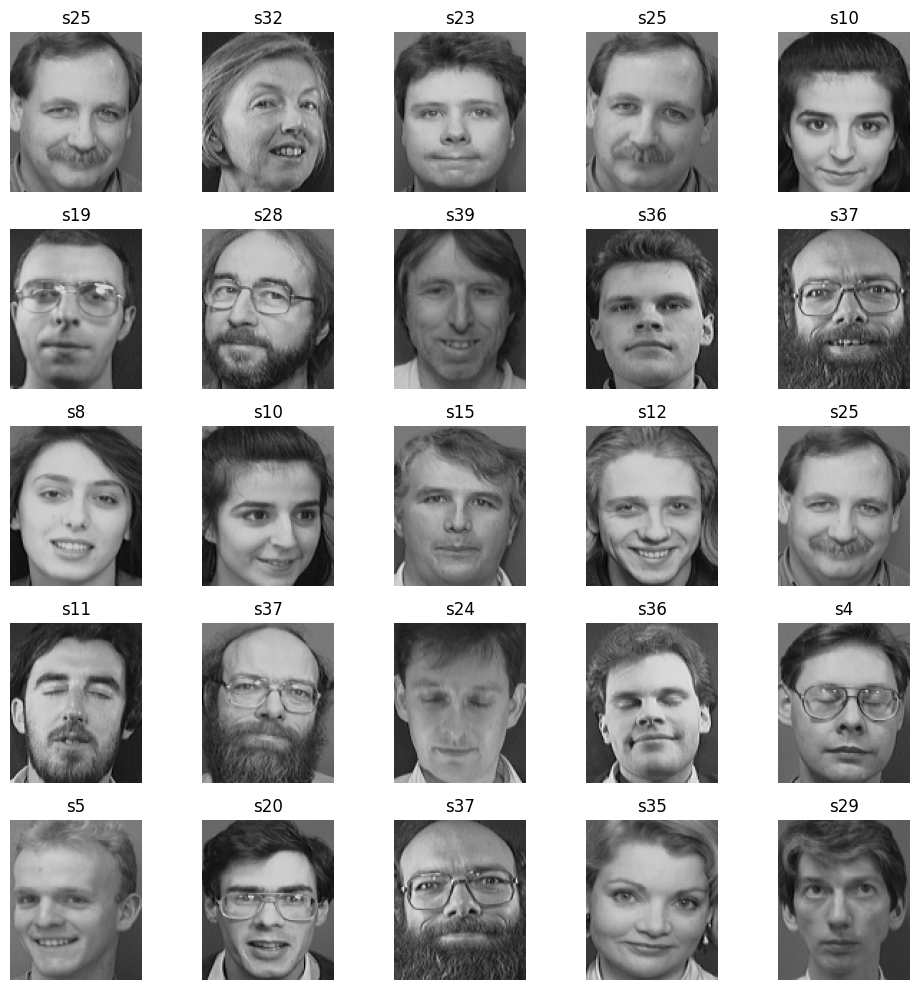

In [ ]:
# Define the grid size and figure size
grid_size = 5
fig_size = (10, 10)

# Create the figure and axes objects
fig, axs = plt.subplots(grid_size, grid_size, figsize=fig_size)
axs = axs.ravel()

# Loop through the images and plot them on the grid
for i in range(grid_size*grid_size):
    # Choose a random image
    class_dir = np.random.choice(os.listdir(train_dir))
    img_path = os.path.join(train_dir, class_dir, np.random.choice(os.listdir(os.path.join(train_dir, class_dir))))
    
    # Load the image and plot it on the grid
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(class_dir)

# Show the grid of images
plt.tight_layout()
plt.show()

In [ ]:
# Define paths and parameters
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
input_shape = (224, 224, 3)
num_classes = 40

In [ ]:
# Create data generators with rescaling
train_data_generator = ImageDataGenerator(rescale=1./255)
valid_data_generator = ImageDataGenerator(rescale=1./255)

# Create generators for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=7,
    class_mode='categorical',
    shuffle=True)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=3,
    class_mode='categorical',
    shuffle=False)


Found 280 images belonging to 40 classes.
Found 120 images belonging to 40 classes.


### Fine-tune a VGG19 with 70% of the data and then use fc7 output as features###

In [ ]:
# Load pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Add new classification layers
x = base_model.output
x1 = GlobalAveragePooling2D()(x)
x2 = Dense(4096, activation='relu')(x1)
x3 = Dense(4096, activation='relu')(x2)
prediction = Dense(40,activation = 'softmax')(x3)

# Create new model
model = Model(inputs=base_model.input, outputs=prediction)

#Freeze base model layers
for layer in base_model.layers:
  layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Print the model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Train model on 70% of data
history = model.fit(train_generator, epochs=25, validation_data=valid_generator)


Epoch 1/25
40/40 [==============================] - 418s 10s/step - loss: 3.9193 - accuracy: 0.0214 - val_loss: 3.6754 - val_accuracy: 0.0500
Epoch 2/25
40/40 [==============================] - 401s 10s/step - loss: 3.6235 - accuracy: 0.0357 - val_loss: 3.4020 - val_accuracy: 0.0833
Epoch 3/25
40/40 [==============================] - 398s 10s/step - loss: 3.3056 - accuracy: 0.0536 - val_loss: 3.1581 - val_accuracy: 0.1333
Epoch 4/25
40/40 [==============================] - 359s 9s/step - loss: 3.1001 - accuracy: 0.1071 - val_loss: 2.9786 - val_accuracy: 0.2000
Epoch 5/25
40/40 [==============================] - 394s 10s/step - loss: 2.7825 - accuracy: 0.1679 - val_loss: 2.6306 - val_accuracy: 0.2583
Epoch 6/25
40/40 [==============================] - 363s 9s/step - loss: 2.5597 - accuracy: 0.2036 - val_loss: 2.3586 - val_accuracy: 0.2417
Epoch 7/25
40/40 [==============================] - 414s 10s/step - loss: 2.3457 - accuracy: 0.2536 - val_loss: 2.2031 - val_accuracy: 0.3333
Epoch 8/

###Model Evaluation###

In [ ]:
#final evaluation of the model

scores= model.evaluate(valid_generator, verbose=0)
print("Accuracy = %.2f%% " % (scores[1]*100))

Accuracy = 70.83% 


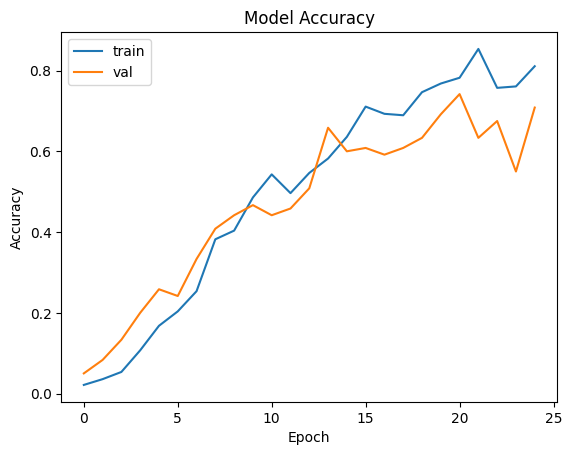

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

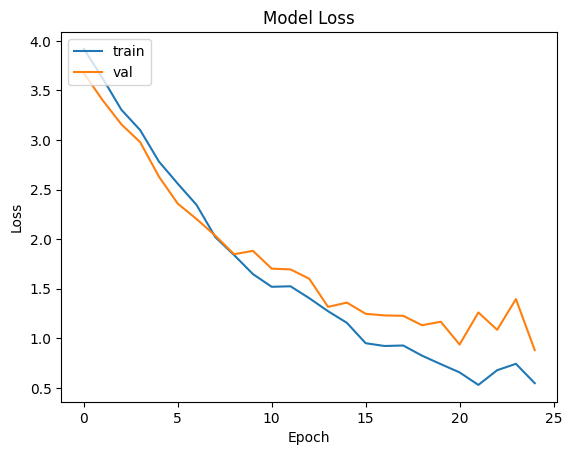

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model = VGG19()
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Extract fc7 layer output for training and validation sets
train_features = model.predict(train_generator)
valid_features = model.predict(valid_generator)



40/40 [==============================] - 100s 3s/step


In [ ]:
# Remove the classification head
model_wo_head = Model(inputs=model.input, outputs=model.get_layer('fc2').output)

# Extract fc7 layer output for training and validation sets
train_features_fc7 = model_wo_head.predict(train_generator)
valid_features_fc7 = model_wo_head.predict(valid_generator)

40/40 [==============================] - 103s 3s/step


###Calculate genuine and impostor score sets and plot their distributions (histograms)###

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

# Create list to store genuine and impostor scores
genuine_scores = []
impostor_scores = []

# Loop through validation data and calculate cosine similarity between enrollment and verifications
for i in range(0, len(valid_generator.filenames), 3):
    enrollment_feature = valid_features_fc7[i]
    verification_feature_1 = valid_features_fc7[i+1]
    verification_feature_2 = valid_features_fc7[i+2]

    # Calculate cosine similarity between enrollment and verification 1
    similarity_1 = cosine_similarity([enrollment_feature], [verification_feature_1])[0][0]
    genuine_scores.append(similarity_1)

    # Calculate cosine similarity between enrollment and verification 2
    similarity_2 = cosine_similarity([enrollment_feature], [verification_feature_2])[0][0]
    genuine_scores.append(similarity_2)

    # Calculate cosine similarity between verification 1 and verification 2
    similarity_3 = cosine_similarity([verification_feature_1], [verification_feature_2])[0][0]
    impostor_scores.append(similarity_3)

# Convert lists to numpy arrays
genuine_scores = np.array(genuine_scores)
impostor_scores = np.array(impostor_scores)


In [ ]:
print(genuine_scores)
print(impostor_scores)

[0.99491096 0.9959873  0.99936116 0.9981784  0.9966629  0.9964429
 0.99771976 0.99766886 0.9903426  0.9912485  0.9987278  0.99722254
 0.99506974 0.99945486 0.99372625 0.99543023 0.9983704  0.99664736
 0.9977863  0.99753827 0.9955876  0.99494255 0.9982376  0.9979848
 0.9911593  0.9900926  0.9950757  0.9922073  0.9980208  0.9972584
 0.99478245 0.9932507  0.9962569  0.99931943 0.9954803  0.9968234
 0.993266   0.99782455 0.99899924 0.99802756 0.9956046  0.99468374
 0.9920218  0.9915274  0.9970641  0.99450725 0.99881434 0.99480957
 0.9843763  0.98388594 0.9962935  0.99561924 0.99914056 0.99389213
 0.99925935 0.9953486  0.99419683 0.9953666  0.9962131  0.9963137
 0.9993272  0.9997363  0.9984149  0.9978118  0.9935983  0.9962232
 0.99877286 0.99396515 0.9967849  0.99498475 0.9975169  0.99829465
 0.9984499  0.99832064 0.99096155 0.9897058  0.99594724 0.99642336
 0.99806654 0.99744326]
[0.9979124  0.9987565  0.999025   0.9991646  0.9990598  0.99776
 0.99527097 0.99471855 0.9977189  0.9984128  0.

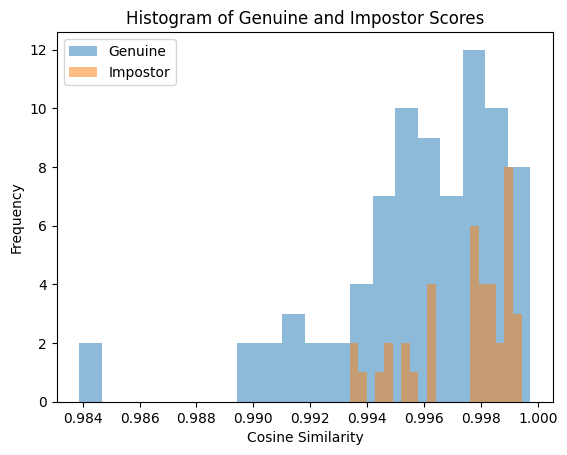

In [ ]:
# Plot histograms for genuine and impostor scores
plt.hist(genuine_scores, bins=20, alpha=0.5, label='Genuine')
plt.hist(impostor_scores, bins=20, alpha=0.5, label='Impostor')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Genuine and Impostor Scores')
plt.legend(loc='upper left')
plt.show()

###ROC curves or score sets###

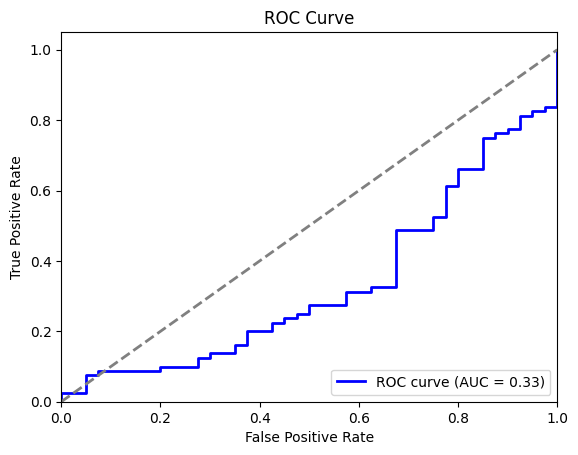

In [ ]:
# Create ROC curve for genuine and impostor scores
y_true = np.concatenate((np.ones(len(genuine_scores)), np.zeros(len(impostor_scores))))
y_scores = np.concatenate((genuine_scores, impostor_scores))
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


###-Apply decision threshold to the validation scores and report on the resulting FAR and GAR### 


In [ ]:
# Find threshold for approximately 1% FAR
far_interp = np.interp(0.01, fpr, thresholds)
far_threshold = thresholds[np.abs(thresholds - far_interp).argmin()]

# Apply decision threshold to validation scores
validation_labels = []
validation_scores = []
for i in range(0, len(valid_generator.filenames), 3):
    enrollment_feature = valid_features_fc7[i]
    verification_feature_1 = valid_features_fc7[i+1]
    verification_feature_2 = valid_features_fc7[i+2]

    # Calculate cosine similarity between enrollment and verification 1
    similarity_1 = cosine_similarity([enrollment_feature], [verification_feature_1])[0][0]
    validation_scores.append(similarity_1)
    validation_labels.append(1)

    # Calculate cosine similarity between enrollment and verification 2
    similarity_2 = cosine_similarity([enrollment_feature], [verification_feature_2])[0][0]
    validation_scores.append(similarity_2)
    validation_labels.append(1)

    # Calculate cosine similarity between verification 1 and verification 2
    similarity_3 = cosine_similarity([verification_feature_1], [verification_feature_2])[0][0]
    validation_scores.append(similarity_3)
    validation_labels.append(0)

# Apply decision threshold
threshold = far_threshold
predictions = (np.array(validation_scores) >= threshold).astype(int)

# Calculate FAR and GAR
false_acceptance = np.sum((predictions == 1) & (np.array(validation_labels) == 0)) / np.sum(np.array(validation_labels) == 0)
genuine_acceptance = np.sum((predictions == 1) & (np.array(validation_labels) == 1)) / np.sum(np.array(validation_labels) == 1)

print('Validation FAR: {:.2%}'.format(false_acceptance))
print('Validation GAR: {:.2%}'.format(genuine_acceptance))


Validation FAR: 0.00%
Validation GAR: 2.50%
